## Run the sanity check on the streamable conv
1. run the vanilla (i.e., non-streamable) conv model in a one-go fashion.
2. run the vanilla (i.e., non-streamable) conv model in a streaming fashion.
3. run the streamable conv model in a streaming fashion.

Remarks
- inference runtime is measured.
- `chunk_size` determines the temporal length of the input to the model.
    - the non-streamable model is expected to perform badly on short chunk size, while the streamable model should.
- error is measured between the outputs of (1., 2.) and (1., 3.).

In [1]:
import os
os.chdir('../')

In [2]:
import os, random
import time
from typing import List

import numpy as np
import torch
import torch.nn as nn
import cached_conv as cc

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # determinism knobs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # cuBLAS reproducibility (PyTorch 1.10+ with CUDA 10.2+)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
    # use deterministic kernels where available
    torch.use_deterministic_algorithms(True, warn_only=True)


class AutoEncoder(nn.Module):
    def __init__(self, dim:int=128):
        super().__init__()
        kernel_size = 7 #3
        stride = 2 #2
        padding = (kernel_size-1)//2 #1
        self.encoder = cc.Sequential(
            cc.Conv1d(1, dim, kernel_size, stride=stride, padding=padding), nn.Tanh(),
            cc.Conv1d(dim, dim, kernel_size, stride=stride, padding=padding), nn.Tanh(),
            cc.Conv1d(dim, dim, kernel_size, stride=stride, padding=padding), nn.Tanh(),
            cc.Conv1d(dim, dim, kernel_size, stride=stride, padding=padding), nn.Tanh(),
            cc.Conv1d(dim, dim, kernel_size, stride=stride, padding=padding), nn.Tanh(),
            cc.Conv1d(dim, dim, kernel_size, stride=stride, padding=padding), nn.Tanh(),
            cc.Conv1d(dim, 1, kernel_size, stride=stride, padding=padding)
        )
        self.total_stride = 2**7  # 2**n_strides
        self.apply(self._init_weights)

    def _init_weights(self, m):
        # cc.Conv1d/ConvTranspose1d usually subclass nn.Conv*, but be robust:
        if hasattr(m, "weight") and isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)) or m.__class__.__name__ in {"Conv1d","ConvTranspose1d"}:
            # Xavier is recommended for tanh
            gain = nn.init.calculate_gain('tanh')
            nn.init.xavier_uniform_(m.weight, gain=gain)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.encoder(x)


def k_folds_by_size(x: torch.Tensor, chunk_size: int, dim: int = -1, drop_last: bool = False) -> List[torch.Tensor]:
    """
    Split `x` into non-overlapping chunks of length `chunk_size` along `dim`.
    The final chunk may be shorter unless `drop_last=True`.

    Args:
        x: input tensor (e.g., waveform shaped (1, T) or (B, T)).
        chunk_size: positive integer length for each chunk.
        dim: dimension to split along (default: time axis at -1).
        drop_last: if True, discard a final shorter chunk.

    Returns:
        List[Tensor]: chunks along `dim`.
    """
    if chunk_size <= 0:
        raise ValueError("chunk_size must be a positive integer")

    chunks = list(torch.split(x, chunk_size, dim=dim))
    if drop_last and chunks and chunks[-1].size(dim) < chunk_size:
        chunks.pop()
    return chunks

In [3]:
cc.use_cached_conv(False)  # must be defined before creating the model instance
set_seed(1234)
model = AutoEncoder()


### inference with vanilla convs

wav.shape: torch.Size([1, 1, 24000])
out.shape: torch.Size([1, 1, 188])


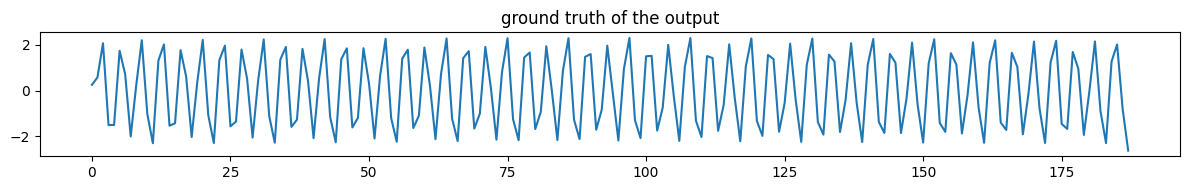

In [4]:
# one-go inference

sr = 24000
length = sr * 10
# wav = torch.randn((1, 1, length))  # (b, c, t)
x_rng = torch.linspace(0, length, length//10).unsqueeze(0).unsqueeze(0)  # (b, c, t)
wav = torch.sin(x_rng)
with torch.no_grad():
    out = model(wav)
out_gt = out.clone()

print('wav.shape:', wav.shape)
print('out.shape:', out.shape)

# plot the output waveform
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 2))
plt.title('ground truth of the output')
plt.plot(out_gt.squeeze().detach().numpy()[:sr//50])
plt.tight_layout()
plt.show()

out.shape: torch.Size([1, 1, 188])


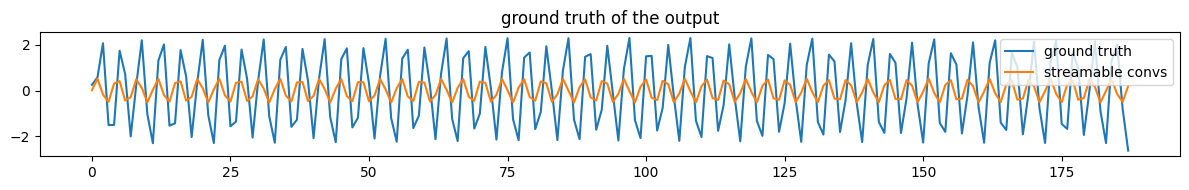

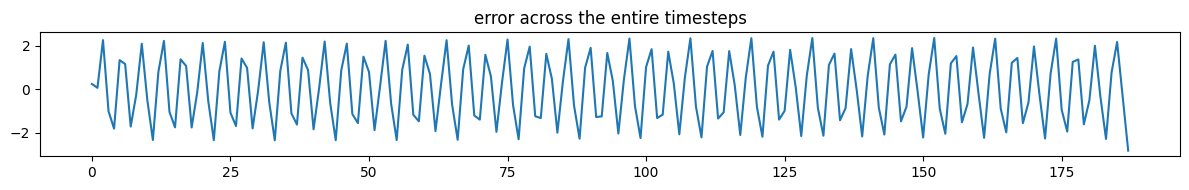

--------------------
[vanilla convs]
chunk_size: 128
duration of the chunk_size: 0.01 [s]
runtime: 0.2225
sum(abs(err)): 257.88953
--------------------


In [5]:
# streaming inference

# Example
chunk_size = model.total_stride * 1  # minimum size = receptive field
chunks = k_folds_by_size(wav, chunk_size=chunk_size, dim=-1)
st_time = time.time()
outs = []
for i, fold in enumerate(chunks):
    # fold has shape (1, chunk_size) except possibly the last one (1, 1000 % chunk_size)
    # print(i, tuple(fold.shape))
    with torch.no_grad():
        out = model(fold)
    outs.append(out)
out = torch.cat((torch.cat(outs[:-1], dim=-1), outs[-1]), dim=-1)
print('out.shape:', out.shape)
end_time = time.time()

# plot the output
from einops import rearrange

plt.figure(figsize=(12, 2))
plt.title('ground truth of the output')
plt.plot(out_gt.squeeze().detach().numpy()[:sr//50], label='ground truth')
plt.plot(out.squeeze().detach().numpy()[:sr//50], label='streamable convs')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# plot the prediction error between the one-go inference and streaming inference
plt.figure(figsize=(12, 2))
plt.title('error across the entire timesteps')
err = out_gt.squeeze().detach().numpy() - out.squeeze().detach().numpy()
plt.plot(err, label='error')
plt.tight_layout()
plt.show()

# log
print('--------------------')
print('[vanilla convs]')
print('chunk_size:', chunk_size)
print('duration of the chunk_size:', round(chunk_size / sr, 2), '[s]')
print('runtime:', round(end_time - st_time, 4))
print('sum(abs(err)):', np.sum(np.abs(err)))
print('--------------------')


### inference with streamable convs

In [6]:
cc.use_cached_conv(True)  # must be defined before creating the model instance; streamable convs
set_seed(1234)
model = AutoEncoder()

chunk_size: 128
duration of the chunk_size: 0.01 [s]
runtime: 0.2692


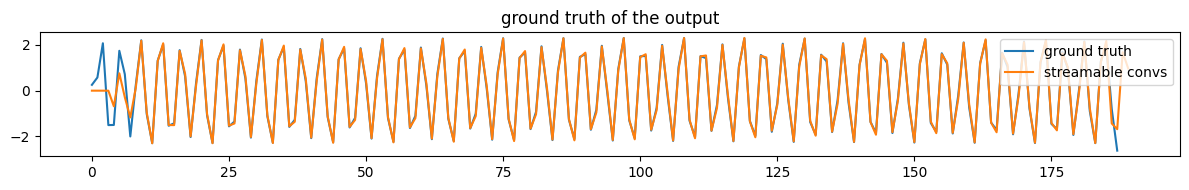

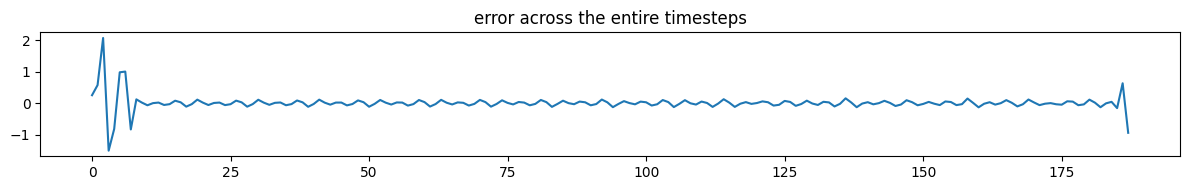

--------------------
[cached convs]
chunk_size: 128
duration of the chunk_size: 0.01 [s]
runtime: 0.2692
sum(abs(err)): 18.92237
--------------------


In [ ]:
# Example
# chunk_size = model.total_stride * 64  # minimum size = receptive field
print('chunk_size:', chunk_size)
print('duration of the chunk_size:', round(chunk_size / sr, 2), '[s]')
chunks = k_folds_by_size(wav, chunk_size=chunk_size, dim=-1)
st_time = time.time()
outs = []
for i, fold in enumerate(chunks):
    # fold has shape (1, chunk_size) except possibly the last one (1, 1000 % chunk_size)
    with torch.no_grad():
        out = model(fold)
    outs.append(out)
out = torch.cat((torch.cat(outs[:-1], dim=-1), outs[-1]), dim=-1)
end_time = time.time()
print('runtime:', round(end_time - st_time, 4))

# automatically get the right-sized padding to compensate for the intermal delay (this delay exists for non-causal conv layers)
left_pad_size = 0
errs = []
for i in range(10):
    MIN_LEN = min(out_gt.shape[-1], out.shape[-1])
    left_pad_size_ = i
    out_ = torch.cat((torch.zeros_like(out)[:,:,:left_pad_size_], out), dim=-1)
    err = out_gt.squeeze().detach().numpy()[:MIN_LEN] - out_.squeeze().detach().numpy()[:MIN_LEN]
    err = np.sum(np.abs(err))
    errs.append(err)
idx = np.argmin(errs)
left_pad_size = np.arange(10)[idx]
out = torch.cat((torch.zeros_like(out)[:,:,:left_pad_size], out), dim=-1)

# plot the output
from einops import rearrange

plt.figure(figsize=(12, 2))
plt.title('ground truth of the output')
plt.plot(out_gt.squeeze().detach().numpy()[:sr//50], label='ground truth')
plt.plot(out.squeeze().detach().numpy()[:sr//50], label='streamable convs')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# plot the prediction error between the one-go inference and streaming inference
plt.figure(figsize=(12, 2))
plt.title('error across the entire timesteps')
err = out_gt.squeeze().detach().numpy()[:MIN_LEN] - out.squeeze().detach().numpy()[:MIN_LEN]
plt.plot(err, label='error')
plt.tight_layout()
plt.show()

# log
print('--------------------')
print('[cached convs]')
print('chunk_size:', chunk_size)
print('duration of the chunk_size:', round(chunk_size / sr, 2), '[s]')
print('runtime:', round(end_time - st_time, 4))
print('sum(abs(err)):', np.sum(np.abs(err)))
print('--------------------')


In [8]:
print(out_gt.shape)
print(out.shape)

torch.Size([1, 1, 188])
torch.Size([1, 1, 190])
